## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('notebook')
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
from IPython.display import display
import string
import re
from collections import Counter
from time import time
import base64
import heapq
import nltk
from nltk.corpus import stopwords
import spacy
nlp = spacy.load('en_core_web_sm')
stopwords = stopwords.words('english')
from wordcloud import WordCloud
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords

In [ ]:
# !python -m spacy download en_core_web_lg
# nlp = spacy.load('en_core_web_lg')

## Import Dataset

In [2]:
reviews = pd.read_csv('winemag-data-130k-v2.csv', nrows=5000, usecols=['points', 'title', 'description'], encoding='latin1')
reviews.shape

(5000, 3)

In [3]:
reviews.head()

,description,points,title
0,"Aromas include tropical fruit, broom, brimston...",87,Nicosia 2013 VulkÃ Bianco (Etna)
1,"This is ripe and fruity, a wine that is smooth...",87,Quinta dos Avidagos 2011 Avidagos Red (Douro)
2,"Tart and snappy, the flavors of lime flesh and...",87,Rainstorm 2013 Pinot Gris (Willamette Valley)
3,"Pineapple rind, lemon pith and orange blossom ...",87,St. Julian 2013 Reserve Late Harvest Riesling ...
4,"Much like the regular bottling from 2012, this...",87,Sweet Cheeks 2012 Vintner's Reserve Wild Child...


## Removing Code Syntax from Text 

In [4]:
def normalize_text(text):
    tm1 = re.sub('<pre>.*?</pre>', '', text, flags=re.DOTALL)
    tm2 = re.sub('<code>.*?</code>', '', tm1, flags=re.DOTALL)
    tm3 = re.sub('<[^>]+>©', '', tm1, flags=re.DOTALL)
    return tm3.replace("\n", "")

In [5]:
reviews['description_Cleaned_1'] = reviews['description'].apply(normalize_text)

In [6]:
print('Before normalizing text-----\n')
print(reviews['description'][2])
print('\nAfter normalizing text-----\n')
print(reviews['description_Cleaned_1'][2])

Before normalizing text-----

Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.

After normalizing text-----

Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.


## Define function to cleanup text by removing personal pronouns, stopwords, and puncuation

In [21]:
punctuations = '!"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~©'

def cleanup_text(docs, logging=False):
    texts = []
    doc = nlp(docs, disable=['parser', 'ner'])
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
    tokens = ' '.join(tokens)
    texts.append(tokens)
    return pd.Series(texts)

In [9]:
reviews['description_Cleaned_1'].shape

(5000,)

In [13]:
reviews['description_Cleaned_1'][0]

"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity."

In [14]:
reviews['description_Cleaned_1'][0:2]

0    Aromas include tropical fruit, broom, brimston...
1    This is ripe and fruity, a wine that is smooth...
Name: description_Cleaned_1, dtype: object

In [19]:
reviews['description_Cleaned_1'][0:3].apply(lambda x: print(x,'\n---------------------------------'))

Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity. 
---------------------------------
This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016. 
---------------------------------
Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented. 
---------------------------------


0    None
1    None
2    None
Name: description_Cleaned_1, dtype: object

In [22]:
reviews['Description_Cleaned'] = reviews['description_Cleaned_1'].apply(lambda x: cleanup_text(x, False))

In [23]:
print('Reviews description with punctuatin and stopwords---\n')
print(reviews['description_Cleaned_1'][0])
print('\nReviews description after removing punctuation and stopwrods---\n')
print(reviews['Description_Cleaned'][0])

Reviews description with punctuatin and stopwords---

Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.

Reviews description after removing punctuation and stopwrods---

aromas include tropical fruit broom brimstone dry herb . palate overly expressive offer unripene apple citrus dry sage alongside brisk acidity .


## Understand the distribution of `points`

* Here points mean number of upvote the description got in social media(such as facebook,twitter etc)

In [30]:
reviews[['Description_Cleaned','title','points']].head()

,Description_Cleaned,title,points
0,aromas include tropical fruit broom brimstone ...,Nicosia 2013 VulkÃ Bianco (Etna),87
1,ripe fruity wine smooth still structure . firm...,Quinta dos Avidagos 2011 Avidagos Red (Douro),87
2,tart snappy flavor lime flesh rind dominate . ...,Rainstorm 2013 Pinot Gris (Willamette Valley),87
3,pineapple rind lemon pith orange blossom start...,St. Julian 2013 Reserve Late Harvest Riesling ...,87
4,much like regular bottling 2012 come across ra...,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,87


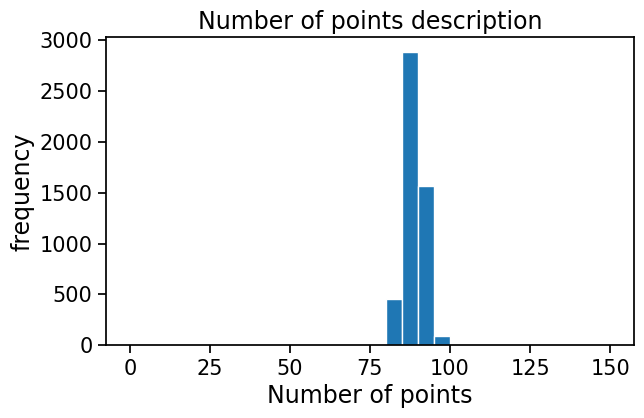

In [26]:
plt.subplot(1, 2, 1)
(reviews['points']).plot.hist(bins=30, figsize=(15,4), edgecolor='white', range=[0,150])
plt.xlabel('Number of points', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Number of points description', fontsize=17)
plt.show()

* The distributions of points lies between 80 to 100 mostly.
* Majority of the description/ Description_Cleaned got points between 80 to 100.

## Analyze Reviews Description

In [ ]:
reviews['Title_len'] = reviews['Description_Cleaned'].str.split().str.len()
rev = reviews.groupby('Title_len')['points'].mean().reset_index()
trace1 = go.Scatter(
    x = rev['Title_len'],
    y = rev['points'],
    mode = 'lines+markers',
    name = 'lines+markers'
)
layout = dict(title= 'Average points by wine description Length',
              yaxis = dict(title='Average points'),
              xaxis = dict(title='wine description Length'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

In [31]:
reviews[['Description_Cleaned','title','points']].head()

,Description_Cleaned,title,points
0,aromas include tropical fruit broom brimstone ...,Nicosia 2013 VulkÃ Bianco (Etna),87
1,ripe fruity wine smooth still structure . firm...,Quinta dos Avidagos 2011 Avidagos Red (Douro),87
2,tart snappy flavor lime flesh rind dominate . ...,Rainstorm 2013 Pinot Gris (Willamette Valley),87
3,pineapple rind lemon pith orange blossom start...,St. Julian 2013 Reserve Late Harvest Riesling ...,87
4,much like regular bottling 2012 come across ra...,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,87


In [37]:
reviews['Description_Cleaned'].str

In [40]:
reviews['Description_Cleaned'].str.split()[0:3]

0    [aromas, include, tropical, fruit, broom, brim...
1    [ripe, fruity, wine, smooth, still, structure,...
2    [tart, snappy, flavor, lime, flesh, rind, domi...
Name: Description_Cleaned, dtype: object

In [41]:
reviews['Description_Cleaned'].str.split().str

In [43]:
reviews['Description_Cleaned'].str.split().str.len()[0:5]

0    22
1    24
2    21
3    24
4    27
Name: Description_Cleaned, dtype: int64

In [ ]:
reviews['Description_len'] = reviews['Description_Cleaned'].str.split().str.len()

In [46]:
reviews[['Description_Cleaned','title','points','Description_len']].head()

,Description_Cleaned,title,points,Description_len
0,aromas include tropical fruit broom brimstone ...,Nicosia 2013 VulkÃ Bianco (Etna),87,22
1,ripe fruity wine smooth still structure . firm...,Quinta dos Avidagos 2011 Avidagos Red (Douro),87,24
2,tart snappy flavor lime flesh rind dominate . ...,Rainstorm 2013 Pinot Gris (Willamette Valley),87,21
3,pineapple rind lemon pith orange blossom start...,St. Julian 2013 Reserve Late Harvest Riesling ...,87,24
4,much like regular bottling 2012 come across ra...,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,87,27


* First groupby `Description_len` and then calculate mean of groupby elements

In [ ]:
rev = reviews.groupby('Description_len')['points'].mean().reset_index()

In [49]:
type(rev)

pandas.core.frame.DataFrame

In [48]:
len(rev)

51

In [47]:
rev[0:5]

,Description_len,points
0,7,81.000
1,8,82.000
2,9,84.000
3,10,83.375
4,11,85.125


In [51]:
trace1 = go.Scatter(
    x = rev['Description_len'],
    y = rev['points'],
    mode = 'lines+markers',
    name = 'lines+markers'
)

type(trace1)

plotly.graph_objs._scatter.Scatter

In [52]:
layout = dict(title= 'Average points by wine description Length',
              yaxis = dict(title='Average points'),
              xaxis = dict(title='wine description Length'))

In [53]:
type(layout)

dict

In [54]:
layout

{'title': 'Average points by wine description Length',
 'yaxis': {'title': 'Average points'},
 'xaxis': {'title': 'wine description Length'}}

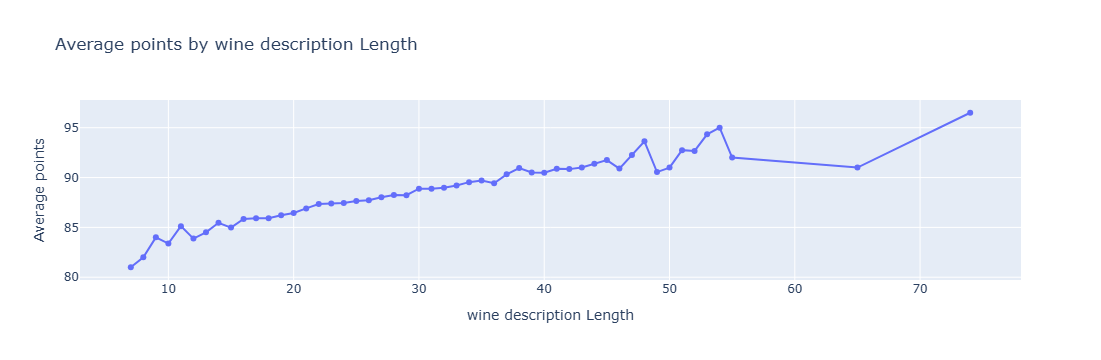

In [55]:
fig = dict(data=[trace1], layout=layout)
py.iplot(fig)

## Function for text summarization

In [56]:
def generate_summary(text_without_removing_dot, cleaned_text):
    sample_text = text_without_removing_dot
    doc = nlp(sample_text)
    sentence_list=[]
    for idx, sentence in enumerate(doc.sents): # we are using spacy for sentence tokenization
        sentence_list.append(re.sub(r'[^\w\s]','',str(sentence)))

    stopwords = nltk.corpus.stopwords.words('english')

    word_frequencies = {}  
    for word in nltk.word_tokenize(cleaned_text):  
        if word not in stopwords:
            if word not in word_frequencies.keys():
                word_frequencies[word] = 1
            else:
                word_frequencies[word] += 1


    maximum_frequncy = max(word_frequencies.values())

    for word in word_frequencies.keys():  
        word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)


    sentence_scores = {}  
    for sent in sentence_list:  
        for word in nltk.word_tokenize(sent.lower()):
            if word in word_frequencies.keys():
                if len(sent.split(' ')) < 30:
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = word_frequencies[word]
                    else:
                        sentence_scores[sent] += word_frequencies[word]


    summary_sentences = heapq.nlargest(7, sentence_scores, key=sentence_scores.get)

    summary = ' '.join(summary_sentences)
    print("Original Text:\n")
    print(text_without_removing_dot)
    print('\n\nSummarized text:\n')
    print(summary)

In [57]:
generate_summary(reviews['description_Cleaned_1'][8], reviews['Description_Cleaned'][8])

Original Text:

Savory dried thyme notes accent sunnier flavors of preserved peach in this brisk, off-dry wine. It's fruity and fresh, with an elegant, sprightly footprint.


Summarized text:

Savory dried thyme notes accent sunnier flavors of preserved peach in this brisk offdry wine Its fruity and fresh with an elegant sprightly footprint


In [58]:
generate_summary(reviews['description_Cleaned_1'][100], reviews['Description_Cleaned'][100])

Original Text:

Fresh apple, lemon and pear flavors are accented by a hint of smoked nuts in this bold, full-bodied Pinot Gris. Rich and a bit creamy in mouthfeel yet balanced briskly, it's a satisfying white with wide pairing appeal. Drink now through 2019.


Summarized text:

Rich and a bit creamy in mouthfeel yet balanced briskly its a satisfying white with wide pairing appeal Fresh apple lemon and pear flavors are accented by a hint of smoked nuts in this bold fullbodied Pinot Gris Drink now through 2019


In [59]:
generate_summary(reviews['description_Cleaned_1'][500], reviews['Description_Cleaned'][500])

Original Text:

Aromas of watermelon and a dusting of natural vanilla mark the bouquet. On the palate, it's fleshy but still crisp and focused, with nectarine, red apple and strawberry flavors. The finish lasts, with some sweetness.


Summarized text:

On the palate its fleshy but still crisp and focused with nectarine red apple and strawberry flavors Aromas of watermelon and a dusting of natural vanilla mark the bouquet The finish lasts with some sweetness
